In [1]:
!pwd

/Users/jamahusseinmohamud/Desktop/research/DM research/large_scale_correlations/large_scale_task_correlation/notebooks


In [1]:
%cd ..

/Users/jamahusseinmohamud/Desktop/research/DM research/large_scale_correlations/large_scale_task_correlation


### Imports

In [2]:
import torch
import math
import csv
import torchvision
from torchvision import transforms
from PIL import Image
from src.models.architectures import ResNet18
import multiprocessing
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, f1_score, average_precision_score

### Label correlation matrix

In [5]:
data_path = '/Users/jamahusseinmohamud/Desktop/research/DM research/large_scale_correlations/large_scale_task_correlation/data/celeb_datasets'
celebData = torchvision.datasets.CelebA(data_path, split='train', target_type = 'attr', transform=transforms.ToTensor(), download = True)

Files already downloaded and verified


In [6]:
celebData.attr_names.remove('')

In [7]:
print(celebData.attr_names)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [8]:
num_workers = multiprocessing.cpu_count()
trainloader = torch.utils.data.DataLoader(
    celebData, batch_size=4, shuffle=True, num_workers=num_workers)


In [9]:
batch = next(iter(trainloader))

In [10]:
batch[1].shape

torch.Size([4, 40])

In [11]:
batch[1]

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]])

In [12]:

multilabel_matrix = torch.zeros((len(celebData), len(celebData.attr_names)))
i = 0
batch_size = 4
for image, labels in trainloader:
    multilabel_matrix[i:i+batch_size] = labels
    i += batch_size

# multilabel_matrix[4:4+batch_size]

In [13]:
len(celebData)

162770

In [14]:
correlation_matrix = np.corrcoef(np.array(multilabel_matrix), rowvar = False)
corr_df = pd.DataFrame(correlation_matrix)
corr_df.columns = celebData.attr_names

In [15]:
correlation_matrix.shape

(40, 40)

Text(0.5, 1.0, 'Train Multi-label correlation Heatmap')

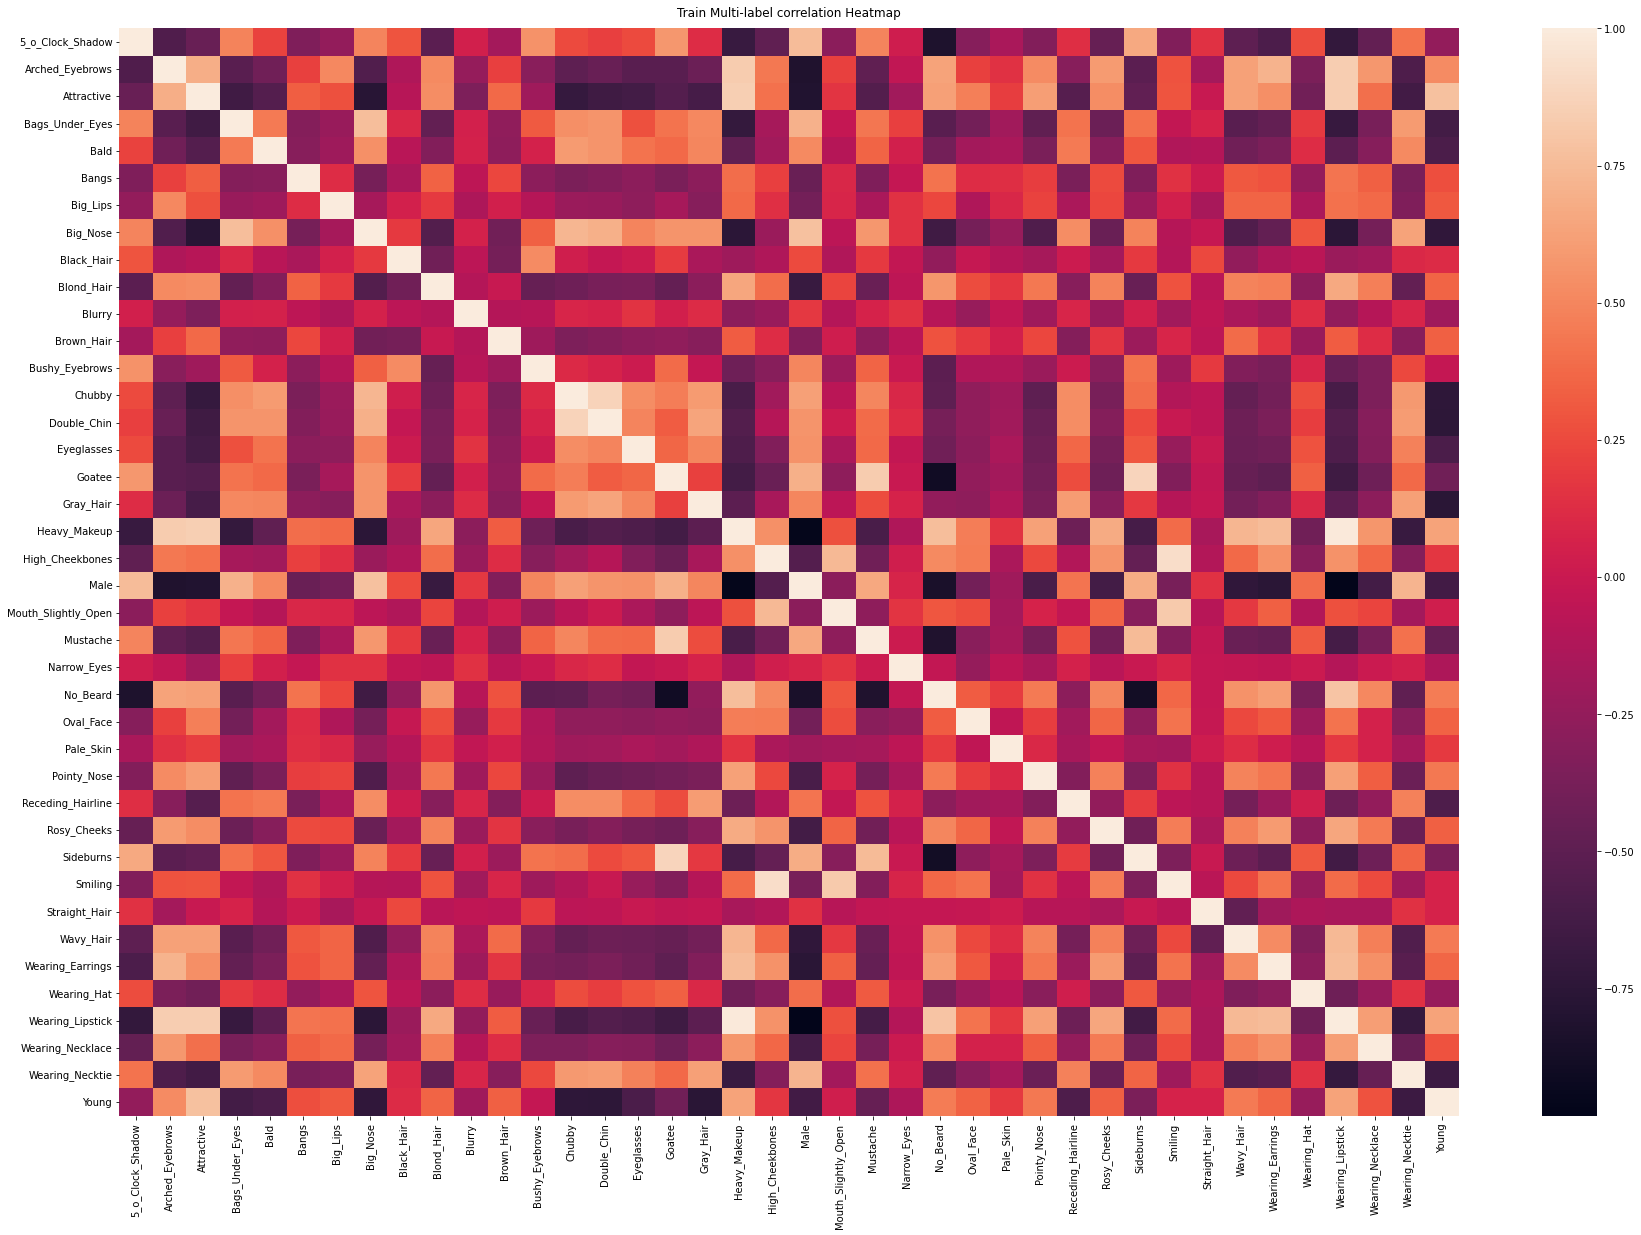

In [16]:
# Increase the size of the heatmap.
plt.figure(figsize=(30, 20))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr_df.corr(), annot=False)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Train Multi-label correlation Heatmap', fontdict={'fontsize':12}, pad=12)

#### SBM

In [17]:
from skmultilearn.cluster.graphtool import StochasticBlockModel

In [24]:
sbm = StochasticBlockModel(
    nested=False, use_degree_correlation=False, allow_overlap=False, weight_model=False
)


In [25]:
sbm.fit_predict(graph=correlation_matrix, weights=None)

TypeError: minimize_blockmodel_dl() got an unexpected keyword argument 'deg_corr'

In [34]:
from graph_tool.all import *

In [37]:
# m = np.array([[0, 1.2, 0],
#               [0, 0, 10],
#               [0, 7, 0]])
# es = np.nonzero(m)
# g = Graph(np.array([es[0], es[1], m[es]]).T, eprops=[("weight", "double")])
# print(g.ep.weight.a)

In [87]:
edge_index = np.nonzero(correlation_matrix)
celeb_graph = Graph(np.array([edge_index[0], edge_index[1], correlation_matrix[edge_index]]).T,  eprops=[("weight", "double")])
print(celeb_graph.ep.weight.a)

[ 1.         -0.15779338 -0.06623495 ...  0.02035452 -0.25128881
  1.        ]


In [86]:
# celeb_graph.vertex_properties["pos"] = celeb_graph.new_vertex_property("vector<double>")
# celeb_graph.vertex_properties

In [74]:
# partition_labels = sbm.fit_predict(graph=celeb_graph, weights=None)
# partition_labels

In [88]:
state = minimize_blockmodel_dl(celeb_graph)
state

<BlockState object with 40 blocks (1 nonempty), degree-corrected, for graph <Graph object, directed, with 40 vertices and 1600 edges, 1 internal edge property, at 0x29171f640>, at 0x2917475e0>

In [102]:
state.get_blocks

<bound method BlockState.get_blocks of <BlockState object with 40 blocks (1 nonempty), degree-corrected, for graph <Graph object, directed, with 40 vertices and 1600 edges, 1 internal edge property, at 0x29171f640>, at 0x2917475e0>>

In [104]:
pos = sfdp_layout(celeb_graph)
pos

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x29171f640, at 0x175845970>

In [105]:
celeb_graph.vp["pos"] = pos

In [106]:
state.draw(pos=celeb_graph.vp["pos"], vertex_shape=state.get_blocks(),
           output="celeb_blocks_mdl.svg")


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x29171f640, at 0x28cbfde20>

In [1]:
import numpy as np
import graph_tool.all as gt

# Define your correlation matrix
# correlation_matrix = np.array([[1, 0.7, 0.3],
#                                [0.7, 1, 0.4],
#                                [0.3, 0.4, 1]])

# Create a graph from the correlation matrix
g = gt.Graph(directed=False)
g.add_vertex(correlation_matrix.shape[0])

# Add edges and edge weights
eweight = g.new_edge_property("double")
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if correlation_matrix[i, j] != 0:
            e = g.add_edge(i, j)
            eweight[e] = correlation_matrix[i, j]

# Set edge weight property
g.ep["eweight"] = eweight

# Fit the Stochastic Block Model (SBM)
state_args = {"eweight": eweight}  # Add eweight parameter to state_args
state = gt.minimize_blockmodel_dl(g, state_args=state_args)
state

In [112]:
# Compute the layout for the graph
pos = gt.sfdp_layout(g, eweight=eweight)

# Prepare the vertex text labels (optional)
vertex_labels = [f"Node {i}" for i in range(correlation_matrix_toy.shape[0])]
vlabel_prop = g.new_vertex_property("string", vals=vertex_labels)

# Draw the graph using the computed layout
gt.graph_draw(
    g,
    pos=pos,
    vertex_text=vlabel_prop,
    vertex_font_size=14,
    vertex_fill_color=state.get_blocks(),
    edge_pen_width=gt.prop_to_size(eweight, mi=1, ma=5),
    output="correlation_sbm_graph.pdf"
)

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x2917559a0, at 0x291798730>

### laplacian clustering

### random split labels into 50/50

In [2]:
celebData = torchvision.datasets.CelebA(
    "datasets/",
    split="all",
    target_type="attr",
    transform=transforms.ToTensor(),
    download=True,
)
celebData.attr_names.remove('')


Files already downloaded and verified


In [3]:
print(celebData.attr_names)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [4]:
first_image_label = celebData[0]

In [5]:
# align image and labels
image_label_names = [
    celebData.attr_names[i]
    for i in range(len(celebData.attr_names))
    if first_image_label[1][i] == 1
]
print(image_label_names)


['Arched_Eyebrows', 'Attractive', 'Brown_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Pointy_Nose', 'Smiling', 'Straight_Hair', 'Wearing_Earrings', 'Wearing_Lipstick', 'Young']


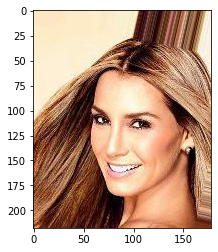

In [6]:
# image = Image.open(first_image_label[0])
plt.imshow(first_image_label[0].permute(1, 2, 0).numpy())
plt.show()

In [24]:
labels_names = np.array(celebData.attr_names)
N = len(labels_names)
indices = np.random.permutation(N)
pret_idx, fine_idx = indices[:N//2], indices[N//2:]
pretrain_labels, finetune_labels = labels_names[pret_idx], labels_names[fine_idx]

In [27]:
len(pretrain_labels), len(finetune_labels)

(20, 20)

In [25]:
pretrain_labels

array(['Narrow_Eyes', 'Eyeglasses', 'Heavy_Makeup', 'Wearing_Lipstick',
       'Blurry', 'Wearing_Necklace', 'Pointy_Nose', 'Big_Nose',
       'Oval_Face', 'Mustache', 'No_Beard', 'Bald', 'Attractive',
       'Bags_Under_Eyes', 'Wearing_Hat', 'Rosy_Cheeks', 'High_Cheekbones',
       'Bushy_Eyebrows', 'Mouth_Slightly_Open', 'Big_Lips'], dtype='<U19')

In [26]:
finetune_labels

array(['Wavy_Hair', 'Arched_Eyebrows', 'Wearing_Earrings', 'Smiling',
       'Brown_Hair', 'Wearing_Necktie', 'Gray_Hair', 'Double_Chin',
       '5_o_Clock_Shadow', 'Sideburns', 'Straight_Hair', 'Chubby',
       'Receding_Hairline', 'Goatee', 'Blond_Hair', 'Male', 'Black_Hair',
       'Young', 'Bangs', 'Pale_Skin'], dtype='<U19')

In [33]:
# np.save(file="datasets/pretrain_labels.npy", arr=pretrain_labels)
# np.save(file="datasets/finetune_labels.npy", arr=finetune_labels)



In [7]:
pretrain_labels = np.load(file="datasets/pretrain_labels.npy")
finetune_labels = np.load(file="datasets/finetune_labels.npy")

In [8]:
pretrain_labels

array(['Narrow_Eyes', 'Eyeglasses', 'Heavy_Makeup', 'Wearing_Lipstick',
       'Blurry', 'Wearing_Necklace', 'Pointy_Nose', 'Big_Nose',
       'Oval_Face', 'Mustache', 'No_Beard', 'Bald', 'Attractive',
       'Bags_Under_Eyes', 'Wearing_Hat', 'Rosy_Cheeks', 'High_Cheekbones',
       'Bushy_Eyebrows', 'Mouth_Slightly_Open', 'Big_Lips'], dtype='<U19')

In [9]:
finetune_labels

array(['Wavy_Hair', 'Arched_Eyebrows', 'Wearing_Earrings', 'Smiling',
       'Brown_Hair', 'Wearing_Necktie', 'Gray_Hair', 'Double_Chin',
       '5_o_Clock_Shadow', 'Sideburns', 'Straight_Hair', 'Chubby',
       'Receding_Hairline', 'Goatee', 'Blond_Hair', 'Male', 'Black_Hair',
       'Young', 'Bangs', 'Pale_Skin'], dtype='<U19')

In [10]:
torch.tensor([1 if pretrain_labels[i] in image_label_names else 0 for i in range(len(pretrain_labels))])

tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [42]:
image_label_names

['Arched_Eyebrows',
 'Attractive',
 'Brown_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Mouth_Slightly_Open',
 'No_Beard',
 'Pointy_Nose',
 'Smiling',
 'Straight_Hair',
 'Wearing_Earrings',
 'Wearing_Lipstick',
 'Young']

In [27]:
bool(set(pretrain_labels.tolist()) & set(finetune_labels.tolist()))


False

### random split dataloader

In [56]:
class iterable_random_celeb_split(torch.utils.data.IterableDataset):
    def __init__(
        self,
        data_path,
        split="train",
        mode="pretrain",
        # batch_size=4,
        transforms=transforms.ToTensor(),
    ):
        super(iterable_random_celeb_split).__init__()
        self.celebData = torchvision.datasets.CelebA(
            root=data_path,
            split=split,
            target_type="attr",
            transform=transforms,
            download=True,
        )
        # remove empty label from label names.
        self.celebData.attr_names.remove("")
        self.mode = mode
        # self.batch_size = batch_size
        # self._generator = self._make_generator()
        self.used_idxs = set()
        if self.mode == "pretrain":
            self.labels = np.load(file=f"{data_path}/pretrain_labels.npy").tolist()
        else:
            self.labels = np.load(file=f"{data_path}/finetune_labels.npy").tolist()

    # def __next__(self):
    #     batch_images = []
    #     batch_labels = []
    #     for _ in range(self.batch_size):
    #         image, image_label = next(self._generator)
    #         batch_images.append(image)
    #         batch_labels.append(image_label)
    #     return torch.stack(batch_images), torch.stack(batch_labels)

    def __iter__(self):
        """Makes a single example generator of the loaded data."""
        idx = 0
        while True:
            # This will reset the index to 0 if we are at the end of the dataset.
            if idx == len(self.celebData):
                idx = idx % len(self.celebData)
                self.used_idxs = set()
                return 
            image, image_labels, image_label_names = self.get_image_by_index(idx)
            if not bool(image_label_names & set(self.labels)):
                idx += 1
                continue
            if idx in self.used_idxs:
                raise Exception(
                    f"Index: {idx} is already used and len used_idxs: {len(self.used_idxs)} and len celebdata: {len(self.celebData)}"
                )
            self.used_idxs.add(idx)
            idx += 1
            image_labels = torch.tensor(
                [
                    1 if self.labels[i] in image_label_names else 0
                    for i in range(len(self.labels))
                ]
            )
            yield image, image_labels

    @property
    def nb_batches(self):
        return len(self.celebData) // self.batch_size

    # def _make_generator(self):
    #     """Makes a single example generator of the loaded data."""
    #     idx = 0
    #     while True:
    #         # This will reset the index to 0 if we are at the end of the dataset.
    #         if idx == len(self.celebData):
    #             idx = idx % len(self.celebData)
    #             self.used_idxs = set()
    #             return 
    #         image, image_labels, image_label_names = self.get_image_by_index(idx)
    #         if not bool(image_label_names & set(self.labels)):
    #             idx += 1
    #             continue
    #         if idx in self.used_idxs:
    #             raise Exception(
    #                 f"Index: {idx} is already used and len used_idxs: {len(self.used_idxs)} and len celebdata: {len(self.celebData)}"
    #             )
    #         self.used_idxs.add(idx)
    #         idx += 1
    #         image_labels = torch.tensor(
    #             [
    #                 1 if self.labels[i] in image_label_names else 0
    #                 for i in range(len(self.labels))
    #             ]
    #         )
    #         yield image, image_labels

    def get_image_by_index(self, idx):
        image, image_labels = self.celebData[idx]
        # align image and labels
        image_label_names = {
            self.celebData.attr_names[i]
            for i in range(len(self.celebData.attr_names))
            if image_labels[i] == 1
        }
        return image, image_labels, image_label_names


In [57]:
# mean and std stats
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        # transforms.RandomCrop(64, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

celeb_train_data = iterable_random_celeb_split(
    data_path="./data/celeb_datasets",
    split="train",
    mode="pretrain",
    # batch_size=128,
    transforms=train_transform,
)
celeb_val_data = iterable_random_celeb_split(
    data_path="./data/celeb_datasets",
    split="valid",
    mode="pretrain",
    # batch_size=128,
    transforms=val_transform,
)


Files already downloaded and verified
Files already downloaded and verified


In [60]:
# celeb_train_data.nb_batches

In [52]:
trainloader = torch.utils.data.DataLoader(celeb_train_data, batch_size=128)
valloader = torch.utils.data.DataLoader(celeb_val_data, batch_size=None)

In [35]:
trainloader.dataset.nb_batches

1271

In [53]:
for i, (images, labels) in enumerate(trainloader):
    # print(images.shape)
    # print(labels.shape)
    # break
    if i % 100 == 0:
        print("batch: ", i, trainloader.dataset.nb_batches)
    break

batch:  0 1271


In [55]:
images.shape, labels.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128, 20]))

### Model development

In [22]:
model = ResNet18()

np_classes = len(celeb_train_data.celebData.attr_names) // 2
inp_features = model.linear.in_features
model.linear = torch.nn.Linear(in_features=inp_features, out_features=np_classes)

# test model on images
outputs = model(images)
outputs[0]


tensor([-0.1200,  0.1784, -0.5673, -0.6353,  0.3002, -0.6812,  0.7377, -0.0211,
         0.6529, -0.2732, -0.2030,  1.3627,  0.0255,  0.5208, -0.2960, -0.0303,
         1.1138,  0.3199,  0.2059,  0.9104], grad_fn=<SelectBackward0>)

In [25]:
outputs.shape, labels.shape

(torch.Size([128, 20]), torch.Size([128, 20]))

In [26]:
loss = torch.nn.BCEWithLogitsLoss()(outputs, labels.float())
print(f'loss: {loss}')

loss: 0.7243784666061401


In [33]:
predicted = torch.round(torch.sigmoid(outputs))
predicted.data

tensor([[1., 1., 0.,  ..., 0., 0., 1.],
        [1., 1., 0.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        ...,
        [1., 1., 0.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        [1., 0., 0.,  ..., 1., 0., 1.]])

In [31]:
labels

tensor([[0, 0, 1,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 0, 0, 1],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 0]])

In [35]:
correct = predicted.data.eq(labels.data).cpu().sum()
correct

tensor(1349)

In [72]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    mps_device = torch.device("mps")

In [73]:
import os

use_cuda = True
result_folder = "./resultsPretrain/"
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

if use_cuda:
    model.to(mps_device)
    model = torch.nn.DataParallel(model)
    print("Using mps accelerator..")


Using mps accelerator..


In [74]:
base_learning_rate = 0.0001
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=base_learning_rate, momentum=0.9, weight_decay=1e-4
)


In [75]:
def scores(y_true, y_pred):
    AP = average_precision_score(y_true, y_pred, average='samples')
    f1 = f1_score(y_true, y_pred, average='samples')
    return AP, f1

In [76]:
##@title Training & Test functions


def train(model, trainset, epoch, np_classes):
    print("\nEpoch: %d" % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    predicted_labels = []
    all_targets = []
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=None)
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.to(mps_device), targets.to(mps_device)

        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets.squeeze())
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.round(torch.sigmoid(outputs))
        all_targets.append(targets.detach().cpu())
        predicted_labels.append(predicted.detach().cpu())
        total += targets.size(0)
        assert predicted.shape == targets.shape
        correct += predicted.eq(targets.data).cpu().sum()

        if batch_idx % 100 == 0:
            print(
                batch_idx,
                trainloader.dataset.nb_batches,
                "Loss: %.3f | Acc: %.3f%% (%d/%d)"
                % (
                    train_loss / (batch_idx + 1),
                    100.0 * correct / (total * np_classes),
                    correct,
                    (total * np_classes),
                ),
            )

    all_targets = np.concatenate(all_targets)
    predicted_labels = np.concatenate(predicted_labels)
    AP, f1 = scores(all_targets, predicted_labels)
    return (
        train_loss / batch_idx,
        100.0 * correct / (total * np_classes),
        100.0 * AP,
        100.0 * f1,
    )


def test(model, epoch, validset, outModelName, np_classes):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_targets = []
    predicted_labels = []
    testloader = torch.utils.data.DataLoader(validset, batch_size=None)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            if use_cuda:
                inputs, targets = inputs.to(mps_device), targets.squeeze().to(
                    mps_device
                )

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.float())

            test_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))
            all_targets.append(targets.detach().cpu())
            predicted_labels.append(predicted.detach().cpu())
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

            if batch_idx % 100 == 0:
                print(
                    batch_idx,
                    testloader.dataset.nb_batches,
                    "Loss: %.3f | Acc: %.3f%% (%d/%d)"
                    % (
                        test_loss / (batch_idx + 1),
                        100.0 * correct / (total * np_classes),
                        correct,
                        (total * np_classes),
                    ),
                )

    # Save checkpoint.
    all_targets = np.concatenate(all_targets)
    predicted_labels = np.concatenate(predicted_labels)
    AP, f1 = scores(all_targets, predicted_labels)

    acc = 100.0 * correct / (total * np_classes)
    if acc > best_acc:
        best_acc = acc
        checkpoint(model, acc, epoch, outModelName)
    return (
        test_loss / batch_idx,
        100.0 * correct / (total * np_classes),
        100.0 * AP,
        100.0 * f1,
    )


In [77]:
##@title checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, outModelName):
    # Save checkpoint.
    print('Saving..')
    state = {
        'state_dict': model.state_dict(),
        'acc': acc,
        'epoch': epoch,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpointPretrain'):
        os.mkdir('checkpointPretrain')
    torch.save(state, f'./checkpointPretrain/{outModelName}.t7')

def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = base_learning_rate
    if epoch <= 9 and lr > 0.1:
        # warm-up training for large minibatch
        lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [78]:
##@title start training

best_acc = float('-inf')
max_epochs = 20
outModelName = "pretrain"
logname = result_folder + model.__class__.__name__ + "_pretrain" + ".csv"
if not os.path.exists(logname):
    with open(logname, "w") as logfile:
        logwriter = csv.writer(logfile, delimiter=",")
        logwriter.writerow(
            [
                "epoch",
                "train loss",
                "train acc",
                "test loss",
                "test acc",
                "train F1",
                "test F1",
            ]
        )

for epoch in range(max_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc, train_AP, train_f1 = train(
        model, epoch, np_classes=np_classes
    )
    test_loss, test_acc, test_AP, test_f1 = test(
        model, epoch, outModelName, np_classes=np_classes
    )
    with open(logname, "a") as logfile:
        logwriter = csv.writer(logfile, delimiter=",")
        logwriter.writerow(
            [
                epoch,
                train_loss,
                train_acc.item(),
                test_loss,
                test_acc.item(),
                train_f1.item(),
                test_f1.item(),
            ]
        )

    print(
        f"Epoch: {epoch} | train acc: {np.round(train_acc.item(), 3)} | test acc: {np.round(test_acc.item(), 3)}"
    )
    print(
        f"Epoch: {epoch} | train loss: {np.round(train_loss, 3)} | test loss: {np.round(test_loss, 3)}"
    )
    print(
        f"Epoch: {epoch} | train AP: {np.round(train_AP.item(), 3)} | test AP: {np.round(test_AP.item(), 3)}"
    )
    print(
        f"Epoch: {epoch} | train F1: {np.round(train_f1.item(), 3)} | test F1: {np.round(test_f1.item(), 3)}"
    )



Epoch: 0
0 1271 Loss: 0.770 | Acc: 46.328% (1186/2560)
100 1271 Loss: 0.681 | Acc: 57.156% (147783/258560)
200 1271 Loss: 0.622 | Acc: 65.666% (337892/514560)
300 1271 Loss: 0.584 | Acc: 69.755% (537504/770560)
400 1271 Loss: 0.559 | Acc: 71.968% (738790/1026560)
500 1271 Loss: 0.541 | Acc: 73.353% (940791/1282560)
600 1271 Loss: 0.527 | Acc: 74.314% (1143364/1538560)
700 1271 Loss: 0.517 | Acc: 75.042% (1346672/1794560)
800 1271 Loss: 0.509 | Acc: 75.605% (1550327/2050560)
900 1271 Loss: 0.502 | Acc: 76.067% (1754531/2306560)
1000 1271 Loss: 0.496 | Acc: 76.468% (1959539/2562560)
1100 1271 Loss: 0.491 | Acc: 76.807% (2164849/2818560)
1200 1271 Loss: 0.486 | Acc: 77.104% (2370624/3074560)
1300 1271 Loss: 0.482 | Acc: 77.387% (2577436/3330560)
1400 1271 Loss: 0.479 | Acc: 77.641% (2784634/3586560)
1500 1271 Loss: 0.475 | Acc: 77.877% (2992474/3842560)
1600 1271 Loss: 0.472 | Acc: 78.090% (3200586/4098560)
1700 1271 Loss: 0.469 | Acc: 78.292% (3409272/4354560)
1800 1271 Loss: 0.466 | Ac

KeyboardInterrupt: 

In [ ]:
##@title plot results
results = pd.read_csv(f'./resultsPretrain/ResNet_{outModelName}.csv', sep =',')
results.head()

In [ ]:
train_accuracy = results['train acc'].values
test_accuracy = results['test acc'].values

print(f'Average Accuracy over {max_epochs_target} epochs:', sum(test_accuracy)//len(test_accuracy))
print(f'best accuraccy over {max_epochs_target} epochs:', max(test_accuracy))

In [ ]:
# figureName = 'figure' # change figure name

plt.plot(results['epoch'].values, train_accuracy, label='train')
plt.plot(results['epoch'].values, test_accuracy, label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title(f'Train/Test Accuracy curve for {max_epochs} epochs')
# plt.savefig(f'/content/results/{figureName}.png')
plt.legend()
plt.show()

### Finetuning

In [ ]:
 # delete the backbone network
delete = True
if delete:
    del model
    del celeb_train_data
    del celeb_val_data
    del trainloader
    del testloader
    gc.collect()

In [ ]:
# mean and std stats
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        # transforms.RandomCrop(64, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

celeb_train_finetune_data = iterable_random_celeb_split(
    data_path="datasets/",
    split="train",
    mode="finetune",
    batch_size=128,
    transforms=train_transform,
)
celeb_val_finetune_data = iterable_random_celeb_split(
    data_path="datasets/",
    split="valid",
    mode="finetune",
    batch_size=128,
    transforms=val_transform,
)

trainloader = torch.utils.data.DataLoader(celeb_train_finetune_data, batch_size=None)
valloader = torch.utils.data.DataLoader(celeb_val_finetune_data, batch_size=None)


In [ ]:
model = ResNet18()

checkpointPath = '/content/checkpoint/pretrain.t7'

print(' ===> loading pretrained model from: ', checkpointPath)
if os.path.isfile(checkpointPath):
    state_dict = torch.load(checkpointPath)
    best_acc = state_dict['acc']
    print('Best Accuracy:', best_acc)
    if "state_dict" in state_dict:
        state_dict = state_dict["state_dict"]
    # remove prefixe "module."
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    for k, v in model.state_dict().items():
        if k not in list(state_dict):
            print('key "{}" could not be found in provided state dict'.format(k))
        elif state_dict[k].shape != v.shape:
            print('key "{}" is of different shape in model and provided state dict'.format(k))
            state_dict[k] = v
    msg = model.load_state_dict(state_dict, strict=False)
    print("Load pretrained model with msg: {}".format(msg))
else:
    raise Exception('No pretrained weights found')

In [ ]:
# Freeze the model parameters, you can also freeze some layers only

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.linear.in_features
model.linear = nn.Linear(num_ftrs, num_classes)
model.to(mps_device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    model.linear.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=1e-4,
)

In [ ]:
# check number of trainable params
total_params = sum(p.numel() for p in model.parameters())
trainable_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Total Parameters:', total_params, 'Trainable parameters: ', trainable_total_params)

In [ ]:
##@title start training

max_epochs = 10
outModelName = "finetuned"
logname = result_folder + model.__class__.__name__ + f'_{outModelName}.csv'
if not os.path.exists(logname):
    with open(logname, "w") as logfile:
        logwriter = csv.writer(logfile, delimiter=",")
        logwriter.writerow(
            [
                "epoch",
                "train loss",
                "train acc",
                "test loss",
                "test acc",
                "train F1",
                "test F1",
            ]
        )

for epoch in range(max_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc, train_AP, train_f1 = train(
        model, epoch, np_classes=np_classes
    )
    test_loss, test_acc, test_AP, test_f1 = test(
        model, epoch, outModelName, np_classes=np_classes
    )
    with open(logname, "a") as logfile:
        logwriter = csv.writer(logfile, delimiter=",")
        logwriter.writerow(
            [
                epoch,
                train_loss,
                train_acc.item(),
                test_loss,
                test_acc.item(),
                train_f1.item(),
                test_f1.item(),
            ]
        )

    print(
        f"Epoch: {epoch} | train acc: {np.round(train_acc.item(), 3)} | test acc: {np.round(test_acc.item(), 3)}"
    )
    print(
        f"Epoch: {epoch} | train loss: {np.round(train_loss, 3)} | test loss: {np.round(test_loss, 3)}"
    )
    print(
        f"Epoch: {epoch} | train AP: {np.round(train_AP.item(), 3)} | test AP: {np.round(test_AP.item(), 3)}"
    )
    print(
        f"Epoch: {epoch} | train F1: {np.round(train_f1.item(), 3)} | test F1: {np.round(test_f1.item(), 3)}"
    )
